# Deployable Payload

Preliminary simulation for EuRoC 2024 Concept Report including deployable payload.
`all_info()` is omitted and using `CompareFlights` as notebook would be miles long.


In [1]:
import datetime
import numpy as np
from rocketpy import Environment, SolidMotor, Rocket, Flight
from rocketpy.plots.compare import CompareFlights

## Setup


### 1 - Environment

Assuming:

- Launching 1/2 the runway south across from the paddock
- Launch day is tomorrow (blocked by: forecast)
- Launch elevation is what is listed [here](https://www.google.com/maps/place/km+440,37,+Agua+Todo+o+Ano,+Tramaga,+N2,+Ponte+de+Sor,+Portugal/@39.2078514,-8.0619467,16z/data=!4m6!3m5!1s0xd1839fd579834f7:0xe8dd5943368adb9!8m2!3d39.2084353!4d-8.0567479!16s%2Fg%2F11bvtfqbw5?entry=ttu)


In [2]:
env = Environment(
    latitude=39.207032,
    longitude=-8.058066,
    elevation=440.37,
    date=(datetime.datetime.utcnow() + datetime.timedelta(hours=1)),
)

env.set_atmospheric_model(
    type="Forecast",
    file="GFS",
)

/var/folders/cb/hdthz_ds5kxcy3kxrqpvgbl80000gn/T/ipykernel_47526/1921014378.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date=(datetime.datetime.utcnow() + datetime.timedelta(hours=1)),
/usr/local/Caskroom/miniconda/base/envs/rocketpy_env/lib/python3.12/site-packages/rocketpy/environment/environment.py:2165: UserWarning: Exact chosen launch time is not available in the provided file, using 2024-09-04 18:00:00 UTC instead.
  warnings.warn(


### 2 - Motor


In [3]:
PRO75L645 = SolidMotor(
    thrust_source="assets/motors/Cesaroni_3419L645-P.eng",
    dry_mass=1.68,  # kilograms
    dry_inertia=(0.039, 0.039, 0.0015),  # kg*m^2
    nozzle_radius=37.5 / 1000,  # of nozzle exit in meters
    grain_number=3,  # Number of propellant grains
    grain_density=1815,  # kg/m^3
    grain_outer_radius=37.5 / 1000,  # meters
    grain_initial_inner_radius=29 / 1000,  # meters
    grain_initial_height=157 / 1000,  # meters
    grain_separation=5 / 1000,  # meters
    grains_center_of_mass_position=0.343,
    center_of_dry_mass_position=0.231,  # formula: lenngth of the aft part of the motor / (length of the aft part of the motor + length of the forward part of the motor)
    nozzle_position=0.0,  # relative to the combustion chamber
    burn_time=5.3,  # seconds
    throat_radius=12.5 / 1000,  # meters)
    coordinate_system_orientation="nozzle_to_combustion_chamber",  # Orientation of the coordinate system -> EXTREMLY IMPORTANT
)

### 3 - Masses
Will use `_wp` and `_wp` to signify with or without deployable payload mass respectively.

In [4]:
payload_mass = 1  # in kg
rocket_mass = 5.079 - payload_mass

other_mass = 0.553  # kg (avionics, recovery system, structure, etc)

print(
    "Rocket Mass Without Motor: {:.4} kg (with Payload)".format(
        rocket_mass + payload_mass + other_mass
    )
)
print("Loaded Motor Mass: {:.4} kg".format(PRO75L645.total_mass(0)))
print("Payload Mass: {} kg".format(payload_mass))
print(
    "Fully loaded Rocket Mass: {:.4} kg".format(
        rocket_mass + PRO75L645.total_mass(0) + payload_mass + other_mass
    )
)

Rocket Mass Without Motor: 5.632 kg (with Payload)
Loaded Motor Mass: 3.198 kg
Payload Mass: 1 kg
Fully loaded Rocket Mass: 8.83 kg


## To Apogee


In [5]:
rocket_wp = Rocket(
    radius=0.051,  # (r) body in meters 5.1cm = 0.051m
    mass=rocket_mass + payload_mass + other_mass,  # kg (dry)
    inertia=(1.14, 1.33, 0.3),  # Moments of inertia of the rocket in kg*m^2
    power_off_drag="assets/aero/cd_power_off.csv",  # power-off drag curve csv
    power_on_drag="assets/aero/cd_power_on.csv",  # power-on drag curve csv
    center_of_mass_without_motor=82.6 / 100,
    coordinate_system_orientation="tail_to_nose",  # MUST be relative to the coordinate system defined in the motor
)

rail_buttons_wp = rocket_wp.set_rail_buttons(
    upper_button_position=0.7,  # relative to the rocket nozzle
    lower_button_position=0.15,  # relative to the rocket nozzle
    angular_position=180,  # degrees
)

rocket_wp.add_motor(PRO75L645, position=0)
nose_cone_wp = rocket_wp.add_nose(
    length=0.408, kind="vonKarman", position=1.78
)  # length in meters, relative to nozzle
fin_set_wp = rocket_wp.add_fins(
    n=4,
    root_chord=0.19,  # meters
    tip_chord=0.06,  # meters
    span=0.102,  # meters (aka height)
    position=0.3,  # relative to the rocket nose
    cant_angle=0,  # radians
    airfoil=("assets/aero/clv_alpha.csv", "degrees"),
    sweep_length=0.13,
)

tail_wp = rocket_wp.add_tail(
    top_radius=0.051,  # meters
    bottom_radius=0.041,  # meters
    length=0.07,  # meters
    position=0.07,  # relative to the rocket nose
)
main_para_wp = rocket_wp.add_parachute(
    "Main",  # name
    cd_s=0.8,  # Drag coefficient of the parachute in m^2
    trigger=600,  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)

drogue_para_wp = rocket_wp.add_parachute(
    "Drogue",  # name
    cd_s=0.8,  # Drag coefficient of the parachute in m^2
    trigger="apogee",  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)
flight_wp = Flight(
    rocket=rocket_wp,
    environment=env,
    rail_length=12,  # meters
    inclination=90,  # launch rail (in degrees)
    heading=90,  # launch rail (in degrees)
    terminate_on_apogee=True,
    name="Ascent",
)
flight_wp.export_kml("assets/results/Payload_wp.kml")

File  assets/results/Payload_wp.kml  saved with success!


## Post Apogee
This is the apogee onwards stage. We can set the intitial point to be the apogee of the first flight.

In [6]:
rocket_np = Rocket(
    radius=0.051,  # (r) body in meters 5.1cm = 0.051m
    mass=rocket_mass + other_mass,  # kg (dry)
    inertia=(1.14, 1.33, 0.3),  # Moments of inertia of the rocket in kg*m^2
    power_off_drag="assets/aero/cd_power_off.csv",  # power-off drag curve csv
    power_on_drag="assets/aero/cd_power_on.csv",  # power-on drag curve csv
    center_of_mass_without_motor=82.6 / 100,
    coordinate_system_orientation="tail_to_nose",  # MUST be relative to the coordinate system defined in the motor
)

rail_buttons_np = rocket_np.set_rail_buttons(
    upper_button_position=0.7,  # relative to the rocket nozzle
    lower_button_position=0.15,  # relative to the rocket nozzle
    angular_position=180,  # degrees
)

rocket_np.add_motor(PRO75L645, position=0)
nose_cone_np = rocket_np.add_nose(
    length=0.408, kind="vonKarman", position=1.78
)  # length in meters, relative to nozzle
fin_set_np = rocket_np.add_fins(
    n=4,
    root_chord=0.19,  # meters
    tip_chord=0.06,  # meters
    span=0.102,  # meters (aka height)
    position=0.3,  # relative to the rocket nose
    cant_angle=0,  # radians
    airfoil=("assets/aero/clv_alpha.csv", "degrees"),
    sweep_length=0.13,
)

tail_np = rocket_np.add_tail(
    top_radius=0.051,  # meters
    bottom_radius=0.041,  # meters
    length=0.07,  # meters
    position=0.07,  # relative to the rocket nose
)
main_para_np = rocket_np.add_parachute(
    "Main",  # name
    cd_s=0.8,  # Drag coefficient of the parachute in m^2
    trigger=600,  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)

drogue_para_np = rocket_np.add_parachute(
    "Drogue",  # name
    cd_s=0.8,  # Drag coefficient of the parachute in m^2
    trigger="apogee",  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)

In [7]:
initial_conditions = flight_wp.solution_array[-1]
initial_conditions[initial_conditions == 0] = np.finfo(float).eps

flight_np = Flight(
    rocket=rocket_np,
    environment=env,
    rail_length=12,  # meters
    inclination=90,  # launch rail (in degrees)
    heading=90,  # launch rail (in degrees)
    initial_solution=initial_conditions,
    name="Descent",
)

flight_np.export_kml("assets/results/Payload_np.kml")

File  assets/results/Payload_np.kml  saved with success!


## CanSat flight
Simulating payload as a dummy rocket.

In [8]:
# Assuming payload is cylindrical
payload_radius = 0.0325  # meters
payload_length = 0.115  # meters, can be specified

I_xx = I_yy = (1 / 12) * payload_mass * (3 * payload_radius**2 + payload_length**2)
I_zz = 0.5 * payload_mass * payload_radius**2

payload = Rocket(
    radius=payload_radius,
    mass=payload_mass,
    inertia=(I_xx, I_yy, I_zz),
    power_off_drag=0.5,
    power_on_drag=0.5,
    center_of_mass_without_motor=payload_length
    / 2,  # assuming uniform mass distribution
)

payload_para = payload.add_parachute(
    "Main",  # name
    cd_s=0.8,  # Drag coefficient of the parachute in m^2
    trigger=800,  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)

In [9]:
payload_descent = Flight(
    rocket=payload,
    environment=env,
    rail_length=np.finfo(float).eps,  # doesn't matter
    inclination=0,  # doesn't matter
    heading=0,  # doesn't matter
    initial_solution=initial_conditions,  # deploy at apogee
    name="CanSat Descent",
)
payload_descent.export_kml("assets/results/Payload_cansat.kml")

File  assets/results/Payload_cansat.kml  saved with success!


## Deployable Payload

In [10]:
payload_descent.info()


Initial Conditions

Initial time: 24.840 s
Position - x: -647.45 m | y: 732.48 m | z: 3366.91 m
Velocity - Vx: -22.03 m/s | Vy: 23.91 m/s | Vz: -0.00 m/s
Attitude (quaternions) - e0: 0.543 | e1: -0.137 | e2: -0.689 | e3: -0.459
Euler Angles - Spin φ : -118.99° | Nutation θ: -89.31° | Precession ψ: 38.57°
Angular Velocity - ω1: 0.12 rad/s | ω2: -0.22 rad/s | ω3: 0.04 rad/s
Initial Stability Margin: 0.885 c


Surface Wind Conditions

Frontal Surface Wind Speed: -6.61 m/s
Lateral Surface Wind Speed: -5.74 m/s


Launch Rail

Launch Rail Length: 2.220446049250313e-16 m
Launch Rail Inclination: 0.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 24.840 s
Rail Departure Velocity: 32.515 m/s
Rail Departure Stability Margin: 0.885 c
Rail Departure Angle of Attack: 0.681°
Rail Departure Thrust-Weight Ratio: 0.000
Rail Departure Reynolds Number: 1.225e+05


Burn out State

Burn out time: 1.000 s
Altitude at burn out: 3366.906 m (ASL) | 3201.980 m (AGL)
Rocket speed at b

## Full Simulation

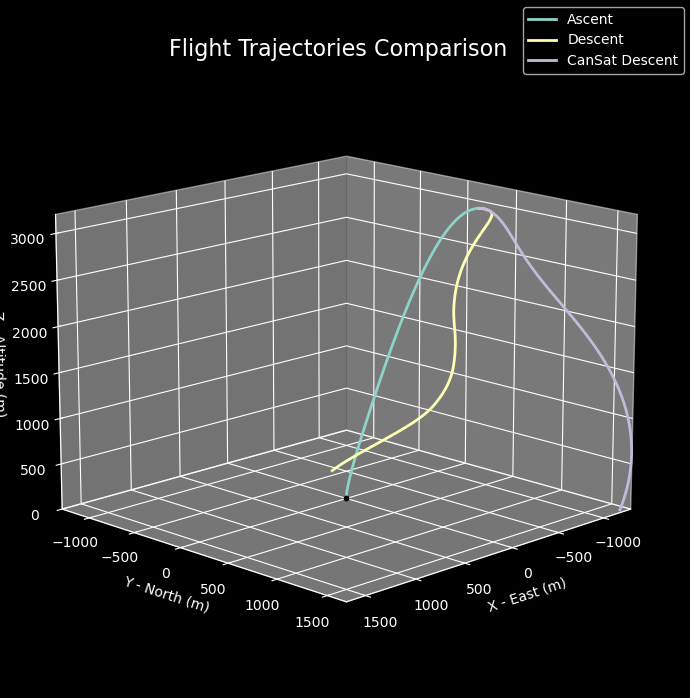

In [11]:
comparison = CompareFlights(
    [flight_wp, flight_np, payload_descent],
)

comparison.trajectories_3d(legend=True)